In [1]:
from bokeh.io import output_file, show, output_notebook, save
from bokeh.plotting import figure

from bokeh.models import ColumnDataSource, HoverTool
from bokeh.models.widgets import Tabs, Panel 
from bokeh.transform import factor_cmap
from bokeh.palettes import *
from bokeh.themes import built_in_themes
from bokeh.io import curdoc
from bokeh.models.annotations import Label, LabelSet


import pandas as pd
import numpy as np 

import geopandas as gpd
from pathlib import Path
import matplotlib.colors

In [15]:
output_notebook()

Loading BokehJS ...

In [2]:
micropolis_folder = Path('../../infrarisk/data/networks/micropolis/gis')

In [17]:
# Figure 1: water network + transport network + buildings + rivers
# Figure 2: water network + pipes exposed to flood + rivers + original valves
# Figure 3:water network + pipes exposed to flood + rivers + pipe-level valves (-->
# only if valves for each pipe can be visualized properly )

In [9]:
plot_width = 700
plot_height = 600





p_wn_pipe = figure(background_fill_color="white", 
           plot_width=plot_width, 
           height = plot_height,
           title = 'Micropolis Transportation Network',
           x_range=(1000, 8000), 
           y_range=(1000, 6600))

### Data

In [10]:
#function to find nearest coordinate
def find_nearest_value(number, setted_list):
    minimum = float("inf")
    for val in setted_list:
        if abs(val - number) < minimum:
            final_value = val
            minimum = abs(val - number)
    return final_value, number

x = [687, 1186, 2392, 2796, 3203, 3604, 4806, 5602, 7208, 7600, 8442, 6107, 5386]
y = [1207, 2392, 2806, 3218, 3603, 3983, 4412, 4787, 5050, 5323, 5640, 6013, 6405]

# transportation nodes
nodes = gpd.read_file(micropolis_folder/'transpo_junctions.shp', encoding="utf-8")
nodes.id = 'T_J' + nodes.id.astype(str)
#[print(find_nearest_value(x_coord, x)) for x_coord in nodes.centroid.x]
nodes['x'] = [find_nearest_value(x_coord, x)[0] for x_coord in nodes.centroid.x]
nodes['y'] = [find_nearest_value(y_coord, y)[0] for y_coord in nodes.centroid.y]

#links
links = gpd.read_file(micropolis_folder/'transpo_links.shp', encoding="utf-8")
links.id = 'T_L' + links['id'].astype(str)
links['from'] = 'T_J' + links['from'].astype(str)
links.to = 'T_J' + links.to.astype(str)
del links['geometry']

C:\Users\srijith\AppData\Local\Temp/ipykernel_20052/1260309667.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  nodes['x'] = [find_nearest_value(x_coord, x)[0] for x_coord in nodes.centroid.x]
C:\Users\srijith\AppData\Local\Temp/ipykernel_20052/1260309667.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  nodes['y'] = [find_nearest_value(y_coord, y)[0] for y_coord in nodes.centroid.y]


In [11]:
# water nodes
micropolis_waternodes = pd.read_csv(micropolis_folder/'micropolis_waternodes.csv')
#micropolis_waternodes = micropolis_waternodes[micropolis_waternodes.category != 'Pump']


#water pipes
micropolis_waterlinks = pd.read_csv(micropolis_folder/'micropolis_waterpipes.csv')
micropolis_pipes = micropolis_waterlinks[micropolis_waterlinks.category.isin(
    ['Main pipe', 'Service connector']
)]

micropolis_pumps = micropolis_waterlinks[micropolis_waterlinks.category == "Pump"]
micropolis_valves = micropolis_waterlinks[micropolis_waterlinks.category == "Short pipe"]

#water network
micropolis_waterjuncs = micropolis_waternodes[micropolis_waternodes.category.isin(['Intermediary node', 'Terminal node'])]
micropolis_tanks = micropolis_waternodes[micropolis_waternodes.category.isin(['Tank'])]
micropolis_reservoirs = micropolis_waternodes[micropolis_waternodes.category.isin(['Reservoir'])]


#water streams
micropolis_streams = gpd.read_file(micropolis_folder/'streams_v1.shp', encoding="utf-8")
micropolis_streams.ID = micropolis_streams.index + 1

#water bodies
micropolis_waterbodies = gpd.read_file(micropolis_folder/'waterbody_v1.shp', encoding="utf-8")

In [12]:
#micropolis buildings
micropolis_buildings = gpd.read_file(micropolis_folder/'buildings_v1.shp', encoding="utf-8")

### Plot 1: Water network and power network topologies

In [13]:
power_color = 'dimgray'
line_alpha = 0.7
line_width = 1.5

transpo_color = 'red'
transpo_line_width = 1

water_color = 'blue'
water_width = 1

palette = Plasma[6][0:4] #YlGnBu[9][0:4] #YlGnBu

buildings_alpha = 1
building_pal = Set3

In [23]:
p_wntn = figure(background_fill_color="white", 
           plot_width=plot_width, 
           height = plot_height,
           title = 'Micropolis Power Network',
           x_range=(1000, 8000), 
           y_range=(1000, 6600))

#streams
x, y = [], []

[
  (x.append(
    list(row['geometry'].coords.xy[0])), 
  y.append(
    list(row['geometry'].coords.xy[1]))
  ) for index, row in micropolis_streams.iterrows() ]

plot_streams = p_wntn.multi_line('x', 'y', source = ColumnDataSource(
  dict(x = x, y = y)), 
                           legend_label="Streams",
                           line_color = "skyblue", alpha = 0.3,
                           muted_color='skyblue', muted_alpha=0.2,
                           line_width = 15)

#water bodies
x, y = [], []
[
  (x.append(
    list(row['geometry'].exterior.xy[0])), 
  y.append(
    list(row['geometry'].exterior.xy[1]))
  ) for index, row in micropolis_waterbodies.iterrows() ]

plot_waterbody = p_wntn.patches('x', 'y', source = ColumnDataSource(
  dict(x = x, y = y)),
                           fill_color = "skyblue", alpha = 0.5,
                           muted_color='skyblue', muted_alpha=0.2,
                           line_width = line_width,
                           legend_label = 'Reservoirs')



#buildings
x, y, facility, population, building_id = [], [], [], [], []
[
  (x.append(
    list(row['geometry'].exterior.coords.xy[0])), 
  y.append(
    list(row['geometry'].exterior.coords.xy[1])),
  facility.append(
    row['FACILITY_T']),
  population.append(
    row['POP']),
  building_id.append(
    row['ID'])
  ) for index, row in micropolis_buildings.iterrows() ]

# building_palette = factor_cmap('type', palette = building_pal[5], factors = np.unique(np.array(building_type)))

plot_buildings = p_wntn.patches('x', 'y', source = ColumnDataSource(dict(x = x, y = y, 
                 facility = facility, population = population, 
                 id = building_id)), 
                           legend_label="Buildings",
                           fill_color= 'gray', fill_alpha = 0.3,
                           line_color = "white",
                           muted_color='white', muted_alpha=0.2,
                           line_width = 0.25)


# junctions
x, y, junc_layer, id = [], [], [], []
[(x.append(row['x']), 
  y.append(row['y']),
  junc_layer.append('Transportation junctions'), 
  id.append(row['id'])) for index, row in nodes.iterrows()]

plot_transpo_juncs = p_wntn.square('x', 'y', source = ColumnDataSource(
  dict(
    x = x, 
    y = y, 
    junc_layer = junc_layer, 
    id = id)), 
                    color=transpo_color, alpha = 0.5,
                    muted_color=transpo_color, muted_alpha=0.2,
                    size = 1)

# Transportation links
x, y, link_layer, link_category, id = [], [], [], [], []
[
  (x.append(
    [nodes[nodes['id'] == row['from']].x, 
     nodes[nodes['id'] == row['to']].x
     ]
    ), 
  y.append(
    [nodes[nodes['id'] == row['from']].y,
     nodes[nodes['id'] == row['to']].y
    ]
    ),
  link_layer.append(
    'Transportation links'
    ),
  link_category.append(
    row['Category']
    ),
  id.append(
    row['id']
    )
  ) for index, row in links.iterrows()]

road_palette = factor_cmap('link_category', palette = palette[0:3], factors = np.unique(np.array(link_category)))

plot_transpo_links = p_wntn.multi_line('x', 'y', source = ColumnDataSource(dict(x = x, y = y, 
      link_layer = link_layer, link_category = link_category, id = id)), 
                                color = transpo_color, line_alpha = line_alpha, 
                                line_width = line_width,
                                muted_color=road_palette, muted_alpha=0.2,
                                line_color = transpo_color,
                                legend_label="Road links")

#wqater network
# junctions
x, y, wnode_layer, wnode_category, wnode_id = [], [], [], [], []
[(x.append(row['x']), 
  y.append(row['y']),
  wnode_layer.append('Water nodes'), 
  wnode_category.append(row['category']),
  wnode_id.append(row['node'])) for index, row in micropolis_waterjuncs.iterrows()]

plot_water_juncs = p_wntn.square('x', 'y', source = ColumnDataSource(dict(x = x, y = y, wnode_layer = wnode_layer, wnode_category = wnode_category, id = wnode_id)), 
                    color=water_color, alpha = 0.4,
                    muted_color=water_color, muted_alpha=0.2,
                    size = 1)

# tanks
x, y, wtank_layer, wtank_id = [], [], [], []
[(x.append(row['x']), 
  y.append(row['y']),
  wtank_layer.append('Water tanks'), 
  wtank_id.append(row['node'])) for index, row in micropolis_tanks.iterrows()]

plot_water_tanks = p_wntn.square('x', 'y', source = ColumnDataSource(dict(x = x, y = y, wtank_layer = wtank_layer, id = wtank_id)), 
                    color=water_color, alpha = 1,
                    muted_color='darkblue', muted_alpha=0.2,
                    size = 10, 
                    legend_label="Water Tank")


# Water pipes 
x, y, pipe_category, pipe_layer, material, diameter, roughness, start_node, end_node = [], [], [], [], [], [], [], [], []
wpipe_id = []
[
  (x.append(
    [micropolis_waternodes[micropolis_waternodes['node'] == row['from']].x, 
     micropolis_waternodes[micropolis_waternodes['node'] == row['to']].x
     ]
    ), 
  y.append(
    [micropolis_waternodes[micropolis_waternodes['node'] == row['from']].y,
     micropolis_waternodes[micropolis_waternodes['node'] == row['to']].y
    ]
    ),
  pipe_layer.append(
    'Water pipes'
    ),
  pipe_category.append(
    row['category']
    ),
  material.append(
    row['material']),
  diameter.append(
    row['diameter']),
  roughness.append(
    row['roughness']),
  wpipe_id.append(
    row['ID']
    ),
  start_node.append(row['from']),
  end_node.append(row['to'])
  ) for index, row in micropolis_pipes.iterrows()]

plot_water_pipes = p_wntn.multi_line('x', 'y', source = ColumnDataSource(dict(x = x, y = y, 
      pipe_layer = pipe_layer, pipe_category = pipe_category, material = material, diameter = diameter, 
      roughness = roughness, id = wpipe_id, start = start_node, end = end_node)),  
                                     line_alpha = line_alpha, line_width = line_width,
                                muted_color=water_color, muted_alpha=0.2,
                                line_color = water_color,
                                legend_label="Water pipes")

# Water pumps
x, y, pump_category, pump_id, start_node, end_node = [], [], [], [], [], []
[
  (x.append(
    [micropolis_waternodes[micropolis_waternodes['node'] == row['from']].x, 
     micropolis_waternodes[micropolis_waternodes['node'] == row['to']].x
     ]
    ), 
  y.append(
    [micropolis_waternodes[micropolis_waternodes['node'] == row['from']].y,
     micropolis_waternodes[micropolis_waternodes['node'] == row['to']].y
    ]
    ),
  pump_category.append(
    'Water pumps'
    ),
  pump_id.append(
    row['ID']
    ),
  start_node.append(row['from']),
  end_node.append(row['to'])
  ) for index, row in micropolis_pumps.iterrows()]

plot_water_pumps = p_wntn.multi_line('x', 'y', source = ColumnDataSource(dict(x = x, y = y, 
      pump_category = pump_category, id = pump_id, start = start_node, end = end_node)),  
                                     line_alpha = line_alpha, line_width = water_width,
                                muted_color=water_color, muted_alpha=0.2,
                                line_color = water_color,
                                line_dash = 'dashed',
                                legend_field="pump_category")

p_wntn.axis.visible = False
p_wntn.grid.visible = False

In [24]:
p_wntn.legend.location = "bottom_left"
p_wntn.legend.click_policy="mute"
p_wntn.legend.background_fill_color = "gainsboro"
p_wntn.legend.background_fill_alpha = 0.3
p_wntn.legend.orientation = "vertical"
show(p_wntn)

### 2. Exposed pipes and branch level valves

In [4]:
list_of_exposed = ["W_PMA536","W_PMA537","W_PMA534","W_PMA535","W_PMA523","W_PMA524","W_PMA525","W_PMA526",
"W_PMA530","W_PMA529","W_PMA522","W_PMA643","W_PMA647","W_PMA646","W_PMA687","W_PMA688",
"W_PMA732","W_PMA864","W_PMA802","W_PMA803","W_PMA804","W_PMA528","W_PMA549","W_PMA550",
"W_PMA1043","W_PMA551","W_PMA644","W_PMA645","W_PMA672","W_PMA673","W_PMA679","W_PMA674",
"W_PMA686","W_PMA863","W_PMA999","W_PMA1000","W_PMA1001","W_PMA1002","W_PMA1003","W_PMA1004",
"W_PMA1005"]

In [5]:
import infrarisk.src.physical.interdependencies as interdependencies
from infrarisk.src.physical.integrated_network import *

In [6]:
network_dir = Path('../../infrarisk/data/networks/micropolis')
water_folder = network_dir/'water/med'
power_folder = network_dir/'power/low'
transpo_folder = network_dir/'transportation/high'

micropolis_network = IntegratedNetwork(name = 'Micropolis', 
                                       water_folder= water_folder,
                                       power_folder = power_folder,
                                       transp_folder=transpo_folder,
                                       water_sim_type = 'PDA',
                                       power_sim_type='1ph')
micropolis_network.generate_integrated_graph()

C:\Users\srijith\anaconda3\envs\redcar\lib\site-packages\wntr\epanet\io.py:2192: UserWarning: Not all curves were used in "..\..\infrarisk\data\networks\micropolis\water\med/water.inp"; added with type None, units conversion left to user
  warnings.warn('Not all curves were used in "{}"; added with type None, units conversion left to user'.format(self.wn.name))


Water network successfully loaded from ..\..\infrarisk\data\networks\micropolis\water\med/water.inp. The analysis type is set to PDA.
initial simulation duration: 60s; hydraulic time step: 60s; pattern time step: 3600s

Power system successfully loaded from ..\..\infrarisk\data\networks\micropolis\power\low\power.json. Single phase power flow simulation will be used.

Transportation network successfully loaded from ..\..\infrarisk\data\networks\micropolis\transportation\high. Static traffic assignment method will be used to calculate travel times.
Successfully added power network to the integrated graph...
Successfully added water network to the integrated graph...
Successfully added transportation network to the integrated graph...
Integrated graph successffully created.
Generating betweenness centrality...


Loading BokehJS ...

In [14]:
micropolis_mains = micropolis_waterlinks[micropolis_waterlinks['category'] == 'Main pipe']
micropolis_mains['exposed'] = [(key in list_of_exposed) for key in micropolis_mains['ID']]

exposed_mains = micropolis_mains[micropolis_mains['exposed'] == True]

In [15]:
G = micropolis_network.water_graph

In [16]:
i = 1
for index, link in enumerate(G.edges.keys()):
    link_id = G.edges[link]["id"]
    if link_id in list_of_exposed:
        G.edges[link]["exposed"] = "Exposed"
        print(i, link_id)
        i += 1
    else:
        G.edges[link]["exposed"] = "Unexposed"

1 W_PMA536
2 W_PMA537
3 W_PMA534
4 W_PMA535
5 W_PMA523
6 W_PMA524
7 W_PMA525
8 W_PMA526
9 W_PMA530
10 W_PMA529
11 W_PMA522
12 W_PMA643
13 W_PMA647
14 W_PMA646
15 W_PMA687
16 W_PMA688
17 W_PMA732
18 W_PMA864
19 W_PMA802
20 W_PMA803
21 W_PMA804
22 W_PMA528
23 W_PMA549
24 W_PMA550
25 W_PMA1043
26 W_PMA551
27 W_PMA644
28 W_PMA645
29 W_PMA672
30 W_PMA673
31 W_PMA679
32 W_PMA674
33 W_PMA686
34 W_PMA863
35 W_PMA999
36 W_PMA1000
37 W_PMA1001
38 W_PMA1002
39 W_PMA1003
40 W_PMA1004
41 W_PMA1005


In [17]:
micropolis_valves.head()

,ID,from,to,category,diameter,roughness,material
1415,W_PV1,W_JVN1464,W_JVN1465,Short pipe,12.0,150.0,Copper
1416,W_PV2,W_JVN1462,W_JVN1463,Short pipe,12.0,150.0,Copper
1417,W_PV3,W_JVN1459,W_JVN1460,Short pipe,12.0,150.0,Copper
1418,W_PV4,W_JVN1457,W_JVN1458,Short pipe,12.0,150.0,Copper
1419,W_PV5,W_JVN1454,W_JVN1455,Short pipe,12.0,150.0,Copper


In [24]:
palette =  tuple(["#32CD32", "#76D021", "#BAD310", "#FFD700", "#FF8F00", "#FF4700", "#FF0000"])

p_wn_branch = figure(background_fill_color="white", 
           plot_width=1000, #plot_width, 
           height = 850, #plot_height,
           title = 'Micropolis Water Network',
           x_range=(1000, 8000), 
           y_range=(1000, 6600))

# instatiate the tile source provider
#tile_provider = get_provider(Vendors.CARTODBPOSITRON_RETINA)

# add the back ground basemap
#p.add_tile(tile_provider, alpha=0.1)

# event area
micropolis_streams1 = list(micropolis_streams['geometry'])
for _, track in enumerate(micropolis_streams1):
    track_buffer = track.buffer(50)

    x, y = [], []
    [
        (
            x.append(list(track_buffer.exterior.coords.xy[0])),
            y.append(list(track_buffer.exterior.coords.xy[1])),
        )
    ]

    p_wn_branch.patches(
            "x",
            "y",
            source=ColumnDataSource(dict(x=x, y=y)),
            fill_color="lightblue",
            fill_alpha=0.5,
            line_color="lightblue",
            line_alpha=0.75,
            legend_label="Floodplains",
        )

# links
x, y, link_layer, link_category, exposed, id = [], [], [], [], [], []
for _, link in enumerate(G.edges.keys()):
    x.append([G.nodes[link[0]]["coord"][0], G.nodes[link[1]]["coord"][0]])
    y.append([G.nodes[link[0]]["coord"][1], G.nodes[link[1]]["coord"][1]])
    link_layer.append(G.edges[link]["link_type"])
    link_category.append(G.edges[link]["link_category"])
    exposed.append(G.edges[link]["exposed"])
    id.append(G.edges[link]["id"])

cmap = factor_cmap('exposed', 
                         palette=(palette[-1], palette[0]), 
                         factors=['Exposed', 'Unexposed'])

plot_exposed_pipes = p_wn_branch.multi_line(
    'x', 'y', source = ColumnDataSource(dict(x = x, y = y, exposed = exposed, id = id)),
                                        line_alpha = line_alpha, line_width = 2*line_width,
                                        muted_color=cmap, muted_alpha=0.2,
                                        line_color = cmap,
                                        legend_field="exposed")

# exposed_df = pd.DataFrame(dict(x = x, y = y, id = id))
# for index, row in exposed_df.iterrows():
#   label = Label(x=row['x'][0], y=row['y'][0], x_offset=5, y_offset=-10, text=row['id'])
#   p_wn_branch.add_layout(label)

#valves
x, y, valve = [], [], []
[
  (x.append(
    micropolis_waternodes[micropolis_waternodes['node'] == row['from']].x.values[0]
    ), 
  y.append(
    micropolis_waternodes[micropolis_waternodes['node'] == row['from']].y.values[0]
  ),
  valve.append(
    row['ID']
  )
  ) for _, row in micropolis_valves.iterrows()]

plot_valves = p_wn_branch.square(
    'x', 'y', source = ColumnDataSource(dict(x = x, y = y, valve = valve)),
                                        size = 5,
                                        muted_color='black', muted_alpha=0.2,
                                        color = 'black', alpha = 0.4,
                                        legend_label="Valves")

# valve_df = pd.DataFrame(dict(x = x, y = y, valve = valve))
# for index, row in valve_df.iterrows():
#   label = Label(x=row['x'], y=row['y'], x_offset=5, y_offset=-10, text=row['valve'])
#   p_wn_branch.add_layout(label)


water_valves_hover = HoverTool(renderers=[plot_valves])
water_valves_hover.tooltips = [('Valve ID', '@valve')]
p_wn_branch.add_tools(water_valves_hover)

water_pipes_hover = HoverTool(renderers=[plot_exposed_pipes])
water_pipes_hover.tooltips = [('Pipe ID', '@id')]
p_wn_branch.add_tools(water_pipes_hover)

p_wn_branch.legend.location = "bottom_left"
p_wn_branch.axis.visible = False
p_wn_branch.grid.visible = False
p_wn_branch.outline_line_color = None
show(p_wn_branch)

# from bokeh.io import export_png
# export_png(p, filename = f"plots/direct_impact.png", webdriver=web_driver)

In [20]:
output_file("../../infrarisk/data/networks/micropolis/exposed_pipes_and_valves.html", title="Micropolis water network")
save(p_wn_branch)

'e:\\dreaminsg_integrated_model\\infrarisk\\data\\networks\\micropolis\\exposed_pipes_and_valves.html'

In [278]:
from shapely.geometry import LineString


p1, p2, link_layer, link_category, exposed, id = [], [], [], [], [], []
for _, link in enumerate(G.edges.keys()):
    p1.append([G.nodes[link[0]]["coord"][0], G.nodes[link[0]]["coord"][1]])
    p2.append([G.nodes[link[1]]["coord"][0], G.nodes[link[1]]["coord"][1]])
    link_layer.append(G.edges[link]["link_type"])
    link_category.append(G.edges[link]["link_category"])
    exposed.append(G.edges[link]["exposed"])
    id.append(G.edges[link]["id"])
    
pipes_df = pd.DataFrame(dict(p1 = p1, p2 = p2, link_layer = link_layer, link_category = link_category, exposed = exposed, id = id))
pipes_df['geometry'] = pipes_df.apply(lambda row: LineString([row['p1'], row['p2']]), axis=1) #Create a linestring column
pipes_df = gpd.GeoDataFrame(pipes_df, geometry='geometry')

C:\Users\srijith\anaconda3\envs\redcar\lib\site-packages\pandas\core\dtypes\cast.py:121: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


In [287]:
pipes_df['geometry']

0       LINESTRING (4963.010 4003.590, 4963.010 3902.030)
1       LINESTRING (4963.010 4003.590, 4911.320 3995.270)
2       LINESTRING (4963.010 4003.590, 5131.760 3995.760)
3       LINESTRING (5234.780 3994.980, 5235.450 3890.980)
4       LINESTRING (5234.780 3994.980, 5205.480 4012.510)
                              ...                        
1618    LINESTRING (6899.770 5489.590, 6932.160 5461.670)
1619    LINESTRING (7097.090 5485.790, 7049.700 5529.490)
1620    LINESTRING (7097.090 5485.790, 7140.110 5511.400)
1621    LINESTRING (7097.090 5485.790, 7061.000 5461.670)
1622    LINESTRING (7097.090 5485.790, 7133.470 5456.000)
Name: geometry, Length: 1623, dtype: geometry

In [383]:
exposed_list = []

for index, row in pipes_df.iterrows():
    if index % 100 == 0:
        print(index, row['id'])
    for index2, row2 in micropolis_streams.iterrows():
        if row['geometry'].intersects(row2['geometry'].buffer(50)):
            if row['id'] not in exposed_list:
                exposed_list.append(row['id'])

0 W_PSC0
100 W_PSC50
200 W_PSC110
300 W_PSC176
400 W_PMA948
500 W_PMA472
600 W_PMA646
700 W_PMA850
800 W_PMA805
900 W_PMA486
1000 W_PMA642
1100 W_PV180
1200 W_PV127
1300 W_PHC4
1400 W_PSC1204
1500 W_PSC1277
1600 W_PSC1359


In [384]:
len([pipe for pipe in exposed_list if pipe.startswith('W_PMA')])

65

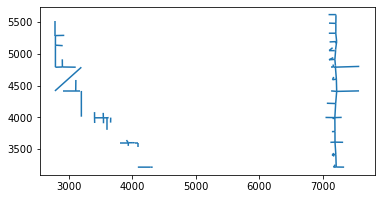

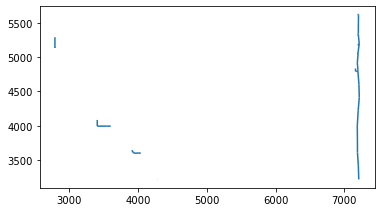

In [401]:
stream_buffer = gpd.GeoDataFrame(geometry = micropolis_streams.buffer(50))
ax = gpd.sjoin(pipes_df, stream_buffer, how='inner', op='intersects').plot()
ax = gpd.sjoin(pipes_df, stream_buffer, how='inner', op='within').plot()

<AxesSubplot:>

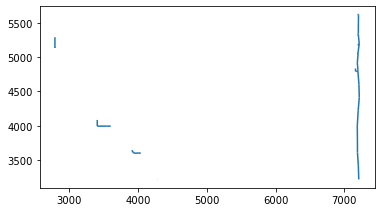

In [396]:
gpd.sjoin(pipes_df, stream_buffer, how='inner', op='within').plot()

<AxesSubplot:>

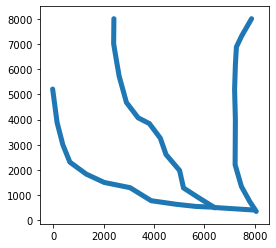

In [387]:
gpd.GeoDataFrame(geometry = micropolis_streams.buffer(100)).plot()